In [21]:
import nest_asyncio
import pandas as pd
nest_asyncio.apply()

import os
from tabulate import tabulate
import copy
import discord
import json
from collections import defaultdict
from discord.ext import commands
from dotenv import load_dotenv

file = open("config.json", "r")
file = json.load(file)
TOKEN = file['token']
GUILD_TOKEN = file['guild_token']

data = pd.DataFrame(columns=['content', 'time', 'author'])

intents = discord.Intents.default()
intents.members = True

members = None
load_dotenv()
bot = commands.Bot(intents=intents, command_prefix='!')
textChannels = None
members = defaultdict(int)
@bot.event
async def on_ready():
    guild = discord.utils.find(lambda g: str(g.id) == GUILD_TOKEN, bot.guilds)
    global textChannels
    textChannels = [channel for channel in guild.channels if (channel.type == discord.ChannelType.text)]
    print(
        f'{bot.user.name} has connected to Discord!',
        f'Server: {guild.name}, Server id: {guild.id}'
    )
@bot.command(name="reset")
async def reset(ctx):
    global textChannels
    textChannels = [channel for channel in guild.channels if (channel.type == discord.ChannelType.text)]
@bot.command(name="parseserver")
async def prepMessages(ctx, arg):
    try:
        arg = int(arg)
    except:
        await ctx.send("counldn't do sorry")
        return
    message = await ctx.send('On it')
    guild = ctx.guild
    # not a dictionary
    global textChannels
    global data
    data = await parseMessages(message,textChannels,arg)
    response = f'Finished! {len(data)} messages parsed'
    await message.edit(content=response)
    
@bot.command(name="parsechannel")
async def parseChannel(ctx,arg1,arg2):
    async def getChannel(channelList):
        if(channelList is None):
            print("Invalid channelList")
            return
        
        channel = discord.utils.get(ctx.guild.channels, id=channelList[0])
        print("got channel")
        return channel
    
    if arg1 is None:
        await ctx.send("Invalid argument, two arguments expected. Received zero")
        return
    if arg2 is None:
        await ctx.send("Invalid argument, two arguments expected. Received one")
        return
    botResponse = await ctx.send(f'Beginning')
    channel = None
    try:
        channelId = int(arg1[2:-1])
        channel = discord.utils.get(ctx.guild.channels, id=channelId)
        print(channel)
        global data
        data = await parseMessages(botResponse, [channel], arg2)
        await botResponse.edit(content=f'Finished parsing {channel.name}! {len(data)} messages parsed')
    except ValueError:
        print('unable to find channel')
        return

    
    
    
        

#skips channel for sever prep
@bot.command(name="skipchannel")
async def skipChannel(ctx, *args):

  
    async def removeChannels(ctx,removeList):
        channelsRemoved = ''
        global textChannels
        for id in removeList:
            channel = discord.utils.get(ctx.guild.channels, id=id)
            textChannels.remove(channel)
            channelsRemoved += channel.name + " "
            
        await ctx.send(f'Successfully prevented  **{channelsRemoved}** from being parsed!')       

    async def printChannels():
        for channel in textChannels:
            print(channel.name, end=' ')
        print('\n')
    
    global textChannels
    removeList = await isChannelValid(ctx,args)
    await removeChannels(ctx,removeList)
    await printChannels()

    
async def isChannelValid(ctx,args):
        channelIds = [channel.id for channel in textChannels]
        i = 0
        removeList = []
        print(args)
        for arg in args:
            #If argument is a channel tag
            if(arg[:2] == '<#' and arg[-1] == '>'):
                #If the channel tag is valid
                if int(arg[2:-1]) in channelIds:
                    removeList.append(int(arg[2:-1]))
                else:
                    await ctx.send('Channel not found')
                    return
            else:
                await ctx.send('Invalid input, expected a channel tag \nTry using #nameOfChannel')
                return
        return removeList
        #await removeChannels(ctx,removeList)
    
                    
async def parseMessages(message,channels,arg):
    arg = int(arg)
    global members
    members = {}
    channelData = pd.DataFrame(columns=['channel', 'content', 'time', 'author'])
    for channel in channels:
        try:
            await message.edit(content=f'Parsing {channel.name}')# replace by editing msg
            channelMessage = await channel.history(limit=arg).flatten()
        except discord.errors.Forbidden as err:
            print(f"Skipping {channel.name}")
            continue    
        channelData = channelData.append(await createDataFrame(channelMessage))
    channelData.to_csv('messages.csv')
    return channelData
        
async def createDataFrame(messages):
    msgData = pd.DataFrame(columns=['channel','content', 'time', 'author'])
    global members
    for msg in messages:
        if msg.author.bot: continue
            
        if msg.author in members:
            members[msg.author] += 1
        else:
            members[msg.author] = 1
        msgData = msgData.append({'channel':msg.channel.name, 'content': msg.content, 'time': msg.created_at, 'author': msg.author}, ignore_index=True)
    return msgData

@bot.command(name="analmsgs")
async def analyzeMessages(ctx):
    df = pd.DataFrame(columns=['Name', "Message_Count"])
    global members
    for user in members:
        df = df.append({'Name':user.name, 'Message_Count': members[user]}, ignore_index=True)
    df = df.sort_values(by=['Message_Count'], ascending=False)
    df.to_csv('rank.csv')
    
    await ctx.send(tabulate(df[:10], showindex=False, headers=df.columns))
    
@bot.command(name="testmsgs")
async def testMessages(ctx):
    messages = pd.read_csv("messages.csv")
    members = {}
    sentMessage = await ctx.send(f'0 parsed messages')
    i = 0
    for ind,row in messages.iterrows():
        i+=1
        if i%500 == 0:
            await sentMessage.edit(content=f'{i} parsed messages')       
            
        if row['author'] in members:
            members[row['author']] += 1
        else:
            members[row['author']] = 1
    df = pd.DataFrame(columns=['Name', "Message_Count"])
    for user in members:
        df = df.append({'Name':user, 'Message_Count': members[user]}, ignore_index=True)
    df = df.sort_values(by=['Message_Count'], ascending=False)
    await ctx.send(f'Top 10 Users: \n{tabulate(df[:10], showindex=False, headers=df.columns)}')
    
    
        
        


bot.run(TOKEN)

KenDiscordBot has connected to Discord! Server: Kappa Beta, Server id: 374312657999757322
('<#733419415651221605>',)
💻buildapcsales 🎌anime vip kens-muted-channel rythm jrpg soggy-lobby basement-board 🤖bot-messages 🎶musix badstreetwear 💈justfuckmyshitup public 🥣general-mills 📈stonks drawings 🎮gaming 🐹pokemon hitlist streetwearinspo 💳credit funny-shit 👌slickdeals 

('<#733249791852544003>',)
💻buildapcsales 🎌anime vip kens-muted-channel rythm jrpg soggy-lobby basement-board 🎶musix badstreetwear 💈justfuckmyshitup public 🥣general-mills 📈stonks drawings 🎮gaming 🐹pokemon hitlist streetwearinspo 💳credit funny-shit 👌slickdeals 

('<#806509784265392150>',)
💻buildapcsales 🎌anime vip kens-muted-channel rythm soggy-lobby basement-board 🎶musix badstreetwear 💈justfuckmyshitup public 🥣general-mills 📈stonks drawings 🎮gaming 🐹pokemon hitlist streetwearinspo 💳credit funny-shit 👌slickdeals 

<Message id=815691569452941332 channel=<TextChannel id=733249791852544003 name='🤖bot-messages' position=12 nsfw=Tru

RuntimeError: Cannot close a running event loop

In [165]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import re
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

df = pd.read_csv('10kmessages.csv')
channels = []
for ind,row in df.iterrows():
    channel = remove_emoji(row['channel'])
    if(channel not in channels):
        channels.append(channel)
members = {}
for ind, row in df.iterrows():
    user = row['author']
    channel = remove_emoji(row['channel'])
    # members = {user : [ { channels : msgCount}, totalMessages] }
    if user in members:
        if channel in members[user][0]:
            members[user][0][channel] += 1
            members[user][0]['!total'] += 1
            members[user][1] +=1
    else:
        members[user] = [{channel: 0 for channel in channels}, 0]
        members[user][0]['!total'] = 1
        members[user][0][channel] = 1
        members[user][1] =1
        

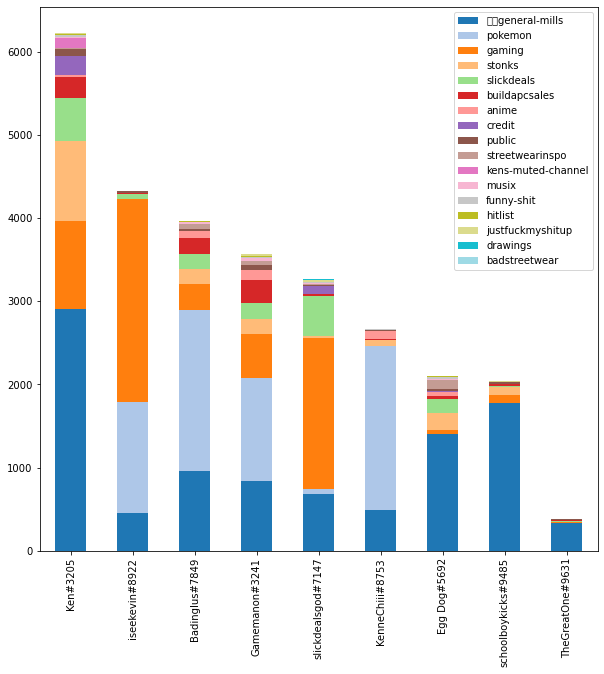

In [197]:
printTotal = False
userMsgThreshold = 300
channelMsgThreshold=150
channelToUser = {channel: {} for channel in channels}
channelToUser['!Total'] = {}

for user in members:
    if members[user][1] >= userMsgThreshold:
        for channel in members[user][0]:
            if channel != '!total':
                channelToUser[channel][user] = members[user][0][channel]
        channelToUser['!Total'][user] = members[user][1]
data = pd.DataFrame(channelToUser)
# sort legend (y-axis) by channel
data.loc['Total'] = data.sum()
data = data.sort_values(by='Total', ascending=False, axis=1)
data = data.sort_values(by='!Total', ascending=False)
if not printTotal:
    data=data.drop('Total',axis=0)
data = data.drop(columns=['!Total'])
# create another entry in df to sum all message counts for each channel
data.plot(kind="bar",stacked=True, figsize=(10,10),colormap='tab20')
plt.show()

In [199]:
# x = channel, legend = user
data = pd.DataFrame({user: members[user][0] for user in members if members[user][1] > 300})

data['!Total'] = data.sum(axis=1)
data.sort_values('!Total',axis=0, ascending=False, inplace=True)
data.sort_values('!total',axis=1, ascending=False, inplace=True)
data = data[data['!Total'] > channelMsgThreshold]
data.drop('!Total',axis=1,inplace=True)
if not printTotal:
    data.drop('!total',axis=0,inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 55358 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 56675 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 55358 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 56675 missing from current font.
  font.set_text(s, 0, flags=flags)


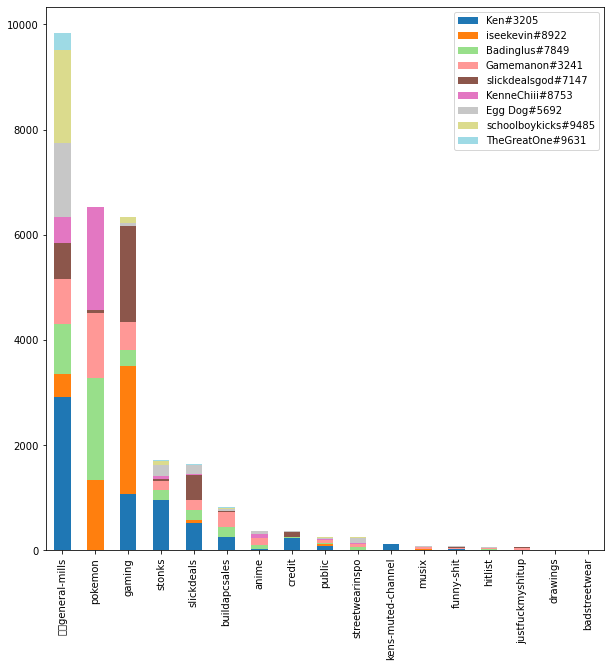

In [200]:
# x = channel, legend = user
data = pd.DataFrame({user: members[user][0] for user in members if members[user][1] > 300})

data['!Total'] = data.sum(axis=1)
data
data.sort_values('!Total',axis=0, ascending=False, inplace=True)
data.sort_values('!total',axis=1, ascending=False, inplace=True)
data.drop('!Total',axis=1,inplace=True)
if not printTotal:
    data.drop('!total',axis=0,inplace=True)
data.plot(kind="bar",stacked=True, figsize=(10,10), colormap='tab20')
plt.show()

#show total label for each bar

#percentage view of each channel instead of raw numbers